Epoch 1/20
34/34 [==============================] - 99s 2s/step - loss: 0.5475 - accuracy: 0.7715 - val_loss: 0.2792 - val_accuracy: 0.9746
Epoch 2/20
34/34 [==============================] - 70s 2s/step - loss: 0.2355 - accuracy: 0.9682 - val_loss: 0.1298 - val_accuracy: 0.9891
Epoch 3/20
34/34 [==============================] - 70s 2s/step - loss: 0.1374 - accuracy: 0.9869 - val_loss: 0.0791 - val_accuracy: 0.9855
Epoch 4/20
34/34 [==============================] - 73s 2s/step - loss: 0.0882 - accuracy: 0.9888 - val_loss: 0.0552 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 73s 2s/step - loss: 0.0672 - accuracy: 0.9906 - val_loss: 0.0449 - val_accuracy: 0.9891
Epoch 6/20
34/34 [==============================] - 72s 2s/step - loss: 0.0504 - accuracy: 0.9925 - val_loss: 0.0355 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 72s 2s/step - loss: 0.0407 - accuracy: 0.9934 - val_loss: 0.0307 - val_accuracy: 0.9964
Epoch 8/20
34/34 [==

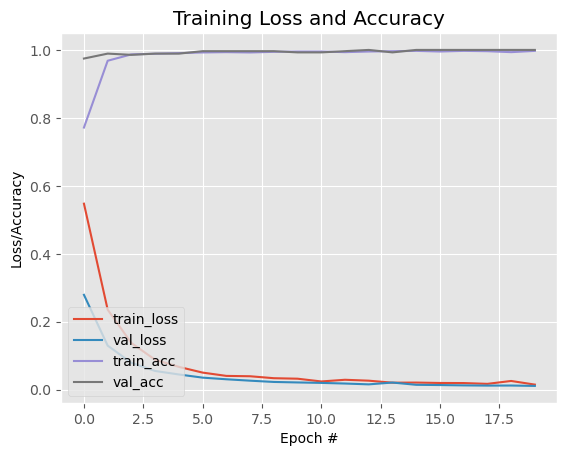

In [1]:
#import necessary dependencies
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

# Define constants
IMAGE_SIZE = (224, 224)
DATA_DIR = "DATA"
NUM_CLASSES = 2
EPOCHS = 20
BATCH_SIZE = 32

# Load and preprocess the data
data = []
labels = []

for class_name in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = load_img(image_path, target_size=IMAGE_SIZE)
        img_array = img_to_array(img)
        image_array = preprocess_input(img_array)

        data.append(image_array)
        labels.append(class_name)

# Convert data and labels to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Perform one-hot encoding of the labels
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Data augmentation for training set
augmentation = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True
)

# Load MobileNetV2 pre-trained model without the top (fully connected) layers
base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet")

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the head model on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(NUM_CLASSES, activation="softmax")(head_model)

# Combine the base model and head model
model = Model(inputs=base_model.input, outputs=head_model)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Train the model
history = model.fit(
    augmentation.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BATCH_SIZE,
    epochs=EPOCHS
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

class_labels = label_binarizer.classes_
print(classification_report(y_true, y_pred, target_names=class_labels))

# Save the model
model.save("mask_detector.model", save_format="h5")

# Plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
